# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment


# Load Reacher env with 20 agents
# env = UnityEnvironment(file_name='Reacher')
env = UnityEnvironment(
    file_name='/home/arasdar/unity-envs/Reacher_Linux_NoVis_OneAgent/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
# print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33


In [4]:
# env_info.rewards

### 3. Instantiate DDPG Agent

In [5]:
from agent import Agent

random_seed = 7

agent = Agent(s_size=state_size, a_size=action_size, random_seed=random_seed)

### 4. Train the Agent with DDPG

In [6]:
from collections import deque
import numpy as np
import time
import torch

n_episodes=1000
R_goal=30 # TOCHECK
R_deque = deque(maxlen=100)
Rs = [] # plot
meanRs_deque = [] # plot

In [ ]:
for i_episode in range(n_episodes):
    
    # Reset Env and Agent
    env_info = env.reset(train_mode=True)[brain_name]       # reset the environment (env)    
    s = env_info.vector_observations[0]                   # get the current state (s) (for an agent)

    R = 0                            # initialize the total score (R) (for an agent)

    #for i_step in range(n_steps):
    while True:
        
        s = np.reshape(s, [1, -1])
        a = agent.act(s) # a: action [-1, +1], s: current state for an agent
        #print(a.shape)
        
        env_info = env.step(a)[brain_name]            # send an action (a) to the environment (env)
        s2 = env_info.vector_observations[0]          # get next state (s) (for an agent)
        r = env_info.rewards[0]                          # get reward (for an agent)
        done = env_info.local_done[0]               # see if episode is done/finished (terminal) for an agent
        if r != 0: print('real reward:', r)
        
        # Exploration vs exploitation
        # noise = np.random.normal(loc=0, scale=0.1, size=[num_agents, action_size])
        # A += noise
        # A = np.clip(a=A, a_min=-1, a_max=1)
        if done is False:
            if np.random.normal(loc=0, scale=1) < 0:
                s2_, _ = agent.env(s, a)
                s2 = np.reshape(s2_, [-1])
                #r_ = r_[0, 0]
                #print('agent.env:', s2.shape, r)
                #print('predicted reward:', r_)
        
        #for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
        #for s, a, r, s2, done in zip(S, A, rewards, S2, dones):
        agent.step(s, a, r, s2, done) # send an exprience (e) to the agent or collecting experiences (E)

        R += r                           # update the total score (for an agent)
        s = s2 # roll over state (s) to the next state (s2)


        # if i_step%learn_every == 0:
        # for _ in range(n_learn):
        gloss, dloss = agent.start_learn()

        if done: # exit loop if episode is done/finished for an agent
            break

    Rs.append(R) # plot
    R_deque.append(R)
    meanRs_deque.append(np.mean(R_deque)) # plot

    print('\rEpisode {}\tTotal Average Score: {:.2f}, \tGloss: {:.2f}, \tDloss: {:.2f}'.format(
        i_episode+1, np.mean(R_deque), gloss, dloss))  
    if np.mean(R_deque) >= R_goal:
        torch.save(agent.g.state_dict(), 'g-reacher.pth')
        torch.save(agent.d.state_dict(), 'd-reacher.pth')
        break

### 5. Plot the result

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

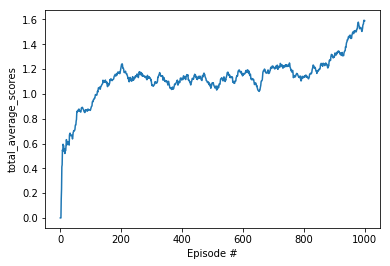

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs_deque)+1), meanRs_deque)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

### 6. Watch the agent running with saved weights

In [7]:
# Load the saved weights into Pytorch model
agent.g.load_state_dict(torch.load('g-reacher.pth', map_location='cpu'))
agent.d.load_state_dict(torch.load('d-reacher.pth', map_location='cpu'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment (env)
s = env_info.vector_observations[0]                  # get the current state (s) (for an agent)
s_ = np.zeros_like(s)

R = 0                          # initialize the total score (R) (for an agent)

while True:
    s = np.reshape(s, [1, -1])
    s_ = np.reshape(s_, [1, -1])
    a = agent.act(s, s_) # select action (a) from loaded model agent
    
    #s2, r, done = env.step(s)
    env_info = env.step(a)[brain_name]           # send an action (a) to the environment (env)
    s2 = env_info.vector_observations[0]         # get next state (s2) (for an agent)
    r = env_info.rewards[0]                     # get reward (for an agent)
    done = env_info.local_done[0]               # see if the episode is done/finished (terminal) for an agent
    
    s2_, _ = agent.env(s, a)
    
    R += r                         # update the total score (R) (for an agent)
    s = s2                               # roll over current state (s) to next state (s2)
    s_ = s2_
    
    if done:                        # exit loop if episode is done/finished for an agent
        break
        
print('Average of total scores: {}'.format(R))

Average of total scores: 39.38999911956489


When finished, you can close the environment.

In [6]:
env.close()